Nour Mansour and Juan Estrella

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

Part 1: Data Collection

Step 1: Get the csv file and the sqlite database data

In [46]:
# Data is saved in the same folder as the project. Then read data from tsv file
data = pd.read_csv("train-balanced-sarcasm.csv")

# This is the database file name
sqlite_file = 'ironate.db'

# Create the connection and cursor
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

# List the tables in the database to see which ones we're interested in
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
tables

,name
0,auth_permission
1,auth_group_permissions
2,auth_group
3,auth_user_groups
4,auth_user_user_permissions
5,django_content_type
6,django_session
7,irony_comment
8,irony_commentsegment
9,irony_label


In [47]:
# Data from the sqlite db
data_2 = pd.read_sql_query("SELECT * FROM irony_commentsegment", conn)
data_2.head()

,id,comment_id,segment_index,text
0,1,1,0,I suspect atheists are projecting their desire...
1,2,1,1,Does anyone remember the crazy preacher with ...
2,3,1,2,\nhttp://www.
3,4,1,3,examiner.
4,5,1,4,com/article/obama-and-wright-throw-each-other-...


In [48]:
# Read the table containing the labels (sarcastic vs not) 
# into another dataframe

labels = pd.read_sql_query("SELECT * FROM irony_label", conn)
labels.head()

,id,segment_id,comment_id,labeler_id,label,confidence,time_given,viewed_thread,viewed_page,forced_decision
0,1,1.0,1,2,-1,2,2013-12-05,0,0,0
1,2,2.0,1,2,-1,2,2013-12-05,0,0,0
2,3,3.0,1,2,-1,2,2013-12-05,0,0,0
3,4,4.0,1,2,-1,2,2013-12-05,0,0,0
4,5,5.0,1,2,-1,2,2013-12-05,0,0,0


In [49]:
# Merge the two dataframes so we have the label and the comment
# in the same dataframe

data_2 = pd.merge(left=data_2,right=labels, left_on='id', right_on='id')
data_2.drop(['segment_id', 'comment_id_y', 'labeler_id', 'confidence', 
             'time_given', 'viewed_thread', 'viewed_page', 'forced_decision', 
             'comment_id_x', 'segment_index'], inplace = True, axis = 1)

data_2.head()

,id,text,label
0,1,I suspect atheists are projecting their desire...,-1
1,2,Does anyone remember the crazy preacher with ...,-1
2,3,\nhttp://www.,-1
3,4,examiner.,-1
4,5,com/article/obama-and-wright-throw-each-other-...,-1


Part 2: Data Processing

Step 1: Columns required: Label, Comments, subreddit, parent comment

Step 2: Create a Dataframe containing an even amount of sarcastic and non sarcastic 
comments, amount of data is 505413 each. 

In [50]:
# Reset the indices after rows with NA values are dropped
data.dropna(inplace=True)
data.drop(['author', 'score', 'ups', 'downs', 'date', 'created_utc', 'subreddit'], axis = 1, inplace = True)
data.reset_index(inplace = True)
data.drop(['index'], axis = 1, inplace = True)
print(data.head())

# Same process for the database dataset
data_2.dropna(inplace=True)
data_2.reset_index(inplace = True)
data_2.drop(['index'], axis = 1, inplace = True)
# label == 0 means "i don't know" so we dropped those to have
# two clear categories
data_2.drop(data_2[data_2.label == 0].index, inplace=True)
print(data_2.shape)
data_2.head()

   label                                            comment  \
0      0                                         NC and NH.   
1      0  You do know west teams play against west teams...   
2      0  They were underdogs earlier today, but since G...   
3      0  This meme isn't funny none of the "new york ni...   
4      0                    I could use one of those tools.   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  
1  The blazers and Mavericks (The wests 5 and 6 s...  
2                            They're favored to win.  
3                         deadass don't kill my buzz  
4  Yep can confirm I saw the tool they use for th...  
(28759, 3)


,id,text,label
0,1,I suspect atheists are projecting their desire...,-1
1,2,Does anyone remember the crazy preacher with ...,-1
2,3,\nhttp://www.,-1
3,4,examiner.,-1
4,5,com/article/obama-and-wright-throw-each-other-...,-1


In [51]:
data.groupby('label').describe()

comment                               parent_comment                  \
        count  unique             top  freq          count  unique     top   
label                                                                        
0      505405  479850             Yes   406         505405  495453  me irl   
1      505368  486357  You forgot the  1451         505368  495295    Why?   

            
      freq  
label       
0      228  
1      148

In [52]:
data_2.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
-1     26186.0  14419.248453  8344.231889   1.0  7187.25  14483.5  21691.75   
 1      2573.0  13980.559658  7851.490657  21.0  7229.00  13401.0  19976.00   

                
           max  
label           
-1     28759.0  
 1     28757.0

We really wanted to use the entire dataset, unfortunately our laptops weren't strong enough to perform the different types of data manipulation and analysis we wanted. 
As a solution, we decided to sample 10% of the dataset each time we ran the program. 10% was actually the largest sample we could get without our Jupyter kernel dying from overflowing Docker's allocated memory resources (we set the memory for Docker to the max value possible given our laptops' specs!). 

In [53]:
data.drop(data[data.comment =='You forgot the'].index, inplace=True)
data.drop(data[data.comment =='you forgot the'].index, inplace=True)
data.drop(data[data.comment =='you dropped this:'].index, inplace=True)
data.drop(data[data.comment =='You dropped this:'].index, inplace=True)
data.drop(data[data.comment =='Forgot the'].index, inplace=True)
data.drop(data[data.comment =='You forgot'].index, inplace=True)
data.drop(data[data.comment =='You forgot your'].index, inplace=True)
data.drop(data[data.comment =='You dropped this'].index, inplace=True)
data.drop(data[data.comment =='I think you forgot the'].index, inplace=True)
data.drop(data[data.comment =='You forgot this:'].index, inplace=True)
data.drop(data[data.comment =='You dropped your'].index, inplace=True)
data.drop(data[data.comment =='I forgot the'].index, inplace=True)
data.drop(data[data.comment =='you forgot'].index, inplace=True)

In [54]:
# Determine size and replacement values
size = int(len(data)*0.5/100)# sample size
replace = True  # with replacement
# Function used to pick random rows from the dataset
# We used the groupby('label') function to choose equal numbers 
# of sarcastic and non-sarcastic comments
fun = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
chosen_data = data.groupby('label', as_index=False).apply(fun)
chosen_data.head()

label                                            comment  \
0 988141      0      Sure it wouldn't... it would take some magic.   
  819321      0                        Montr... oh July, not June.   
  374649      0  He also commented it 4 other times in the thre...   
  453619      0  The mainstory is so complete bullshit that it'...   
  942705      0                       I enjoyed sesevenen as well.   

                                             parent_comment  
0 988141  That wouldn't really work for diamond armour t...  
  819321  A shiting hockey team, but one hell of a party...  
  374649  Nah, he did his job perfectly. That nigga gets...  
  453619  Fallout 3 is still my favorite game of all tim...  
  942705                                         Love Se7en

In [55]:
# Select equal number of sarcastic and non-sarcastic comments
# Determine size and replacement values
size = 2573# sample size of each group being selected
replace = True  # with replacement
data_2 = data_2.groupby('label', as_index=False).apply(fun)
data_2.head()

id                                               text  label
0 4805    4806  Because that thing 'Justice' that you were tau...     -1
  14598  14599                                               usa.     -1
  21595  21596                It's like fox news for progressives     -1
  12474  12475                       creepy washed up never-been.     -1
  1578    1579   If so, there's some hard-hitting journalism o...     -1

In [56]:
# CSV file: Reset the indexes to remove the grouping into 0s and 1s
chosen_data.reset_index(inplace = True)
# Delete the columns that include the names of the indexes created from the groups
chosen_data.drop(['level_0', 'level_1'], inplace = True, axis = 1)
chosen_data.head()

,label,comment,parent_comment
0,0,Sure it wouldn't... it would take some magic.,That wouldn't really work for diamond armour t...
1,0,"Montr... oh July, not June.","A shiting hockey team, but one hell of a party..."
2,0,He also commented it 4 other times in the thre...,"Nah, he did his job perfectly. That nigga gets..."
3,0,The mainstory is so complete bullshit that it'...,Fallout 3 is still my favorite game of all tim...
4,0,I enjoyed sesevenen as well.,Love Se7en


In [57]:
# DB data: Reset the indexes to remove the grouping into -1s and 1s
data_2.reset_index(inplace = True)
# Delete the columns that include the names of the indexes created from the groups
data_2.drop(['level_0', 'level_1'], inplace = True, axis = 1)
data_2.head()

,id,text,label
0,4806,Because that thing 'Justice' that you were tau...,-1
1,14599,usa.,-1
2,21596,It's like fox news for progressives,-1
3,12475,creepy washed up never-been.,-1
4,1579,"If so, there's some hard-hitting journalism o...",-1


In [58]:
data.groupby('label').describe()

comment                    parent_comment                     
        count  unique   top freq          count  unique     top freq
label                                                               
0      505405  479850   Yes  406         505405  495453  me irl  228
1      501218  486344  Who?  149         501218  491218    Why?  147

In [59]:
data_2.groupby('label').describe()

id                                                             \
        count          mean          std   min     25%      50%      75%   
label                                                                      
-1     2573.0  14486.687524  8237.729401  14.0  7521.0  14463.0  21626.0   
 1     2573.0  13961.298484  7805.035355  21.0  7476.0  13220.0  19801.0   

                
           max  
label           
-1     28754.0  
 1     28757.0

Part 3: Exploratory Analysis & Data Visualization

We made sure we got equal number of sarcastic and non-sarcastic comments. From the following histogram, we notice we got 50,000 comments from each group.

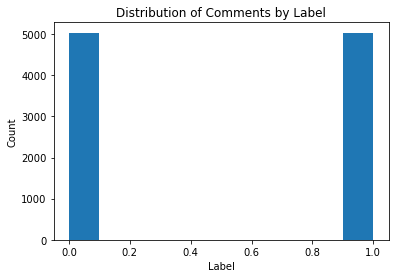

In [60]:
# Explore distribution of the data by label (0 -> non-sarcastic, 1 -> sarcastic)
plt.hist(chosen_data.label)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Comments by Label')
plt.show()

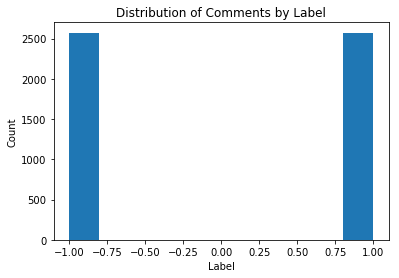

In [61]:
# Explore distribution of the data by label (-1 -> non-sarcastic, 1 -> sarcastic)
plt.hist(data_2.label)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Comments by Label')
plt.show()

In [62]:
#Import NLTK library
# !pip install nltk

In [63]:
import nltk

In [64]:
# nltk.download("all")

In [65]:
from nltk.corpus import stopwords #Use this to get rid of meaningless words like "the, and, a"
from nltk.tokenize import word_tokenize #Split by word
from nltk.tokenize import sent_tokenize #Split by sentence

In [66]:
#Make sure all the comment column is str data type
chosen_data['comment'] = chosen_data['comment'].astype(str)
chosen_data['parent_comment'] = chosen_data['parent_comment'].astype(str)
data_2['text'] = data_2['text'].astype(str)

# Split the comments into words
chosen_data['tok_comment'] = chosen_data['comment'].apply(word_tokenize)
data_2['tok_comment'] = data_2['text'].apply(word_tokenize)
# Apply Parts of Speech tagging on the words
chosen_data['POS_tag'] = chosen_data['tok_comment'].apply(nltk.pos_tag)
data_2['POS_tag'] = data_2['tok_comment'].apply(nltk.pos_tag)
# chosen_data.head()

# Apply stemming on the tokenized comments to get the roots of the words
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

chosen_data['stem'] = chosen_data['tok_comment'].apply(lambda x: [stemmer.stem(y) for y in x])
data_2['stem'] = data_2['tok_comment'].apply(lambda x: [stemmer.stem(y) for y in x])


After confirming our suspicions that using TF-IDF on the raw tokenized comments would yield very modest results, we decided to continue exploring how we can fix our models. First, we used chunking to break up the comments into more meaningful noun phrases. 

Notice how the chunked sentences column groups the nouns into groups with

In [67]:
joined_tag = []
for index, row in chosen_data.iterrows():
    joined_tag.append(' '.join([word + "_" + pos for word, pos in row['POS_tag']]))
chosen_data['joined_POS_tag'] = joined_tag.copy()

# For DB data
joined_tag = []
for index, row in data_2.iterrows():
    joined_tag.append(' '.join([word + "_" + pos for word, pos in row['POS_tag']]))
data_2['joined_POS_tag'] = joined_tag.copy()


In [68]:
# !pip install -U textblob
# from textblob import TextBlob

In [69]:

# Polarity for comment
blob_list = []
for index, row in chosen_data.iterrows():
    blob_list.append(TextBlob(row['comment']))
chosen_data['textblob'] = blob_list.copy()

# chosen_data.head()

polarity_list = []
for index, row in chosen_data.iterrows():
    polarity_list.append(row['textblob'].sentiment.polarity)

chosen_data['polarity'] = polarity_list.copy()

# chosen_data.head()

# print(chosen_data['polarity'].shape)

In [70]:
# Polarity for parent comment

parent_blob_list = []
for index, row in chosen_data.iterrows():
    parent_blob_list.append(TextBlob(row['parent_comment']))
chosen_data['parent_textblob'] = parent_blob_list.copy()


# chosen_data.head()

parent_polarity_list = []
for index, row in chosen_data.iterrows():
    parent_polarity_list.append(row['parent_textblob'].sentiment.polarity)

chosen_data['parent_polarity'] = parent_polarity_list.copy()

# chosen_data.head()

# print(chosen_data['parent_polarity'].shape)

In [71]:
# Polarity for comment
blob_list = []
for index, row in data_2.iterrows():
    blob_list.append(TextBlob(row['text']))
data_2['textblob'] = blob_list.copy()

# chosen_data.head()

polarity_list = []
for index, row in data_2.iterrows():
    polarity_list.append(row['textblob'].sentiment.polarity)

data_2['polarity'] = polarity_list.copy()

# print(data_2['polarity'].shape)
# data_2.head()

In [72]:

chosen_data['joined_stem'] = chosen_data['stem'].apply(lambda x: ' '.join(x))
data_2['joined_stem'] = data_2['stem'].apply(lambda x: ' '.join(x))
# chosen_data.head()

### Predicting Sarcasm

We were interested in trying different models for predicting a sarcastic comment.
To determine the features and labels for the analysis, we decided to look at the comment itself as a feature and use the given sarcastic vs non-sarcastic classification as our label.

Various articles and studies looked at sarcasm and attempted to predict using different features. For instance, an online tutorial only looked at TF-IDF as a feature, so we decided we wanted to experiment with that and see if we would get anything remotely close to their findings. Worth noting, however, that they looked at tweets with the #sarcasm tag, their dataset was significantly smaller than ours (N= ), and their training vs test data split was slightly unusual (training = 95%, test = 5%). 

To create a more reliable model, we decided to split our data into the more common 80-20 split for training and test subsets respectively. We also chose three main models to compare, acknowledging that some of them might fare slightly more poorly compared to the others. We also assumed TF-IDF vectorization of the comments alone would not be a good predictor for whether a comment is sarcastic or not. 

The three models we picked were:
1. Logistic regression
2. Support Vector Machine
3. Random forest

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [74]:
X_train, X_test, y_train, y_test = train_test_split(chosen_data[['joined_POS_tag', 'joined_stem', 'polarity', 'parent_polarity']] , chosen_data.label, test_size=0.2, random_state=0)
X_train.head()

,joined_POS_tag,joined_stem,polarity,parent_polarity
787,``_`` Who_WP cares_VBZ about_IN education_NN w...,`` who care about educ when we can line our po...,0.000000,0.135417
4007,Italian_JJ charm_NN bracelets_NNS ._.,italian charm bracelet .,0.000000,0.700000
3188,"I_PRP did_VBD ,_, and_CC I_PRP am_VBP wonderin...","i did , and i am wonder how the dnc rig the pr...",0.400000,0.000000
4763,Haha_NNP also_RB tested_VBD it_PRP on_IN HoV_N...,haha also test it on hov last week : p fk that...,0.316667,0.034091
8120,TIL_NNP engineers_NNS are_VBP fit_JJ ._.,til engin are fit .,0.400000,-0.266667


In [75]:
# For the database
db_X_train, db_X_test, db_y_train, db_y_test = train_test_split(data_2[['joined_POS_tag', 'joined_stem', 'polarity']] , data_2.label, test_size=0.2, random_state=0)
db_X_train.head()

,joined_POS_tag,joined_stem,polarity
1936,'_'' ''_'' ]_NN (_( http_NN :_: //e_NN ._.,' '' ] ( http : //e .,0.000000
2509,:_: (_(,: (,-0.750000
872,Always_NNS ironic_VBP to_TO see_VB a_DT guy_NN...,"alway iron to see a guy like reich , who 's al...",0.302841
831,We_PRP 'd_MD have_VB better_JJR chance_NN of_I...,we 'd have better chanc of get ray comfort giv...,0.500000
1813,really_RB is_VBZ a_DT circle-jerk_JJ waste_NN ...,realli is a circle-jerk wast of energi .,0.000000


In [76]:
# TF-IDF to vectorize the data
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
stem_vectorizer = TfidfVectorizer(ngram_range = (1,3)) # ask about max features
tfidf_stem = stem_vectorizer.fit_transform(X_train.joined_stem)

pos_vectorizer = TfidfVectorizer(ngram_range = (1,3))
tfidf_pos = pos_vectorizer.fit_transform(X_train.joined_POS_tag)

combined_2 = sp.hstack([tfidf_stem, tfidf_pos], format = 'csr')
combined_3 = sp.hstack((combined_2,np.array(X_train.polarity)[:,None]))
combined_4 = sp.hstack((combined_3,np.array(X_train.parent_polarity)[:,None]))

# test_stem_vectorizer = TfidfVectorizer(max_features = 10000) # ask about max features
test_tfidf_stem = stem_vectorizer.transform(X_test.joined_stem)

# test_pos_vectorizer = TfidfVectorizer(max_features = 10000)
test_tfidf_pos = pos_vectorizer.transform(X_test.joined_POS_tag)

test_combined_2 = sp.hstack([test_tfidf_stem, test_tfidf_pos], format = 'csr')
test_combined_2.shape

test_combined_3 = sp.hstack((test_combined_2,np.array(X_test.polarity)[:,None]))
test_combined_4 = sp.hstack((test_combined_3,np.array(X_test.parent_polarity)[:,None]))

In [77]:
db_stem_vectorizer = TfidfVectorizer(ngram_range = (1,3)) # ask about max features
db_tfidf_stem = db_stem_vectorizer.fit_transform(db_X_train.joined_stem)

db_pos_vectorizer = TfidfVectorizer(ngram_range = (1,3))
db_tfidf_pos = db_pos_vectorizer.fit_transform(db_X_train.joined_POS_tag)

db_combined_2 = sp.hstack([db_tfidf_stem, db_tfidf_pos], format = 'csr')

db_combined_3 = sp.hstack((db_combined_2,np.array(db_X_train.polarity)[:,None]))

## Test data vectorizing

# test_stem_vectorizer = TfidfVectorizer(max_features = 10000) # ask about max features
db_test_tfidf_stem = db_stem_vectorizer.transform(db_X_test.joined_stem)

# test_pos_vectorizer = TfidfVectorizer(max_features = 10000)
db_test_tfidf_pos = db_pos_vectorizer.transform(db_X_test.joined_POS_tag)

db_test_combined_2 = sp.hstack([db_test_tfidf_stem, db_test_tfidf_pos], format = 'csr')
db_test_combined_2.shape

db_test_combined_3 = sp.hstack((db_test_combined_2,np.array(db_X_test.polarity)[:,None]))

In [78]:
# Logistic Regression

log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(combined_4, y_train)

# Logistic regression score
print("Training score: ", log_clf.score(combined_4, y_train))
print("Test score: ", log_clf.score(test_combined_4, y_test))

Training score:  0.9875807252856433
Test score:  0.6564051638530288


In [79]:
# Logistic Regression for DB data

db_log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(db_combined_3, db_y_train)

# Logistic regression score
print("Training score: ", db_log_clf.score(db_combined_3, db_y_train))
print("Test score: ", db_log_clf.score(db_test_combined_3, db_y_test))

Training score:  0.9834791059280855
Test score:  0.6893203883495146


In [80]:
# SVM model
svm_clf = LinearSVC()

# Training the model
svm_clf.fit(combined_4, y_train)

print("Training score: ", svm_clf.score(combined_4, y_train))
print("Test score: ", svm_clf.score(test_combined_4, y_test))

Training score:  0.9981371087928465
Test score:  0.6459781529294936


In [81]:
# SVM model
db_svm_clf = LinearSVC()

# Training the model
db_svm_clf.fit(db_combined_3, db_y_train)

print("Training score: ", db_svm_clf.score(db_combined_3, db_y_train))
print("Test score: ", db_svm_clf.score(db_test_combined_3, db_y_test))

Training score:  0.9856656948493683
Test score:  0.6912621359223301


In [82]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators = 100)

rf_clf.fit(combined_4, y_train)

print("Training score: ", rf_clf.score(combined_4, y_train))
print("Test score: ", rf_clf.score(test_combined_4, y_test))

Training score:  0.9997516145057128
Test score:  0.6226415094339622


In [83]:
# Random Forest Classifier

db_rf_clf = RandomForestClassifier(n_estimators = 100)

db_rf_clf.fit(db_combined_3, db_y_train)

print("Training score: ", db_rf_clf.score(db_combined_3, db_y_train))
print("Test score: ", db_rf_clf.score(db_test_combined_3, db_y_test))

Training score:  0.9861516034985423
Test score:  0.7126213592233009


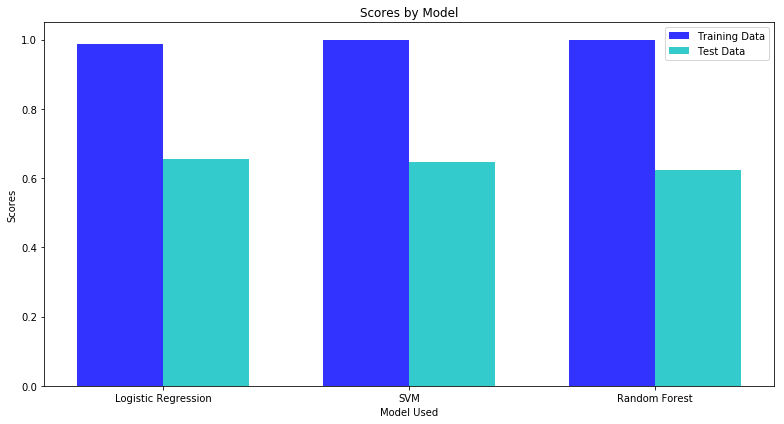

In [84]:
# data to plot
n_groups = 3
train_score = [log_clf.score(combined_4, y_train), 
          svm_clf.score(combined_4, y_train),
          rf_clf.score(combined_4, y_train)]
test_score = [log_clf.score(test_combined_4, y_test), 
          svm_clf.score(test_combined_4, y_test),
          rf_clf.score(test_combined_4, y_test)]

# create plot
fig, ax = plt.subplots(figsize=(11, 6))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, train_score, bar_width,
alpha=opacity,
color='b',
label='Training Data')

rects2 = plt.bar(index + bar_width, test_score, bar_width,
alpha=opacity,
color='c',
label='Test Data')

plt.xlabel('Model Used')
plt.ylabel('Scores')
plt.title('Scores by Model')
plt.xticks(index + bar_width/2, ('Logistic Regression', 'SVM', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()

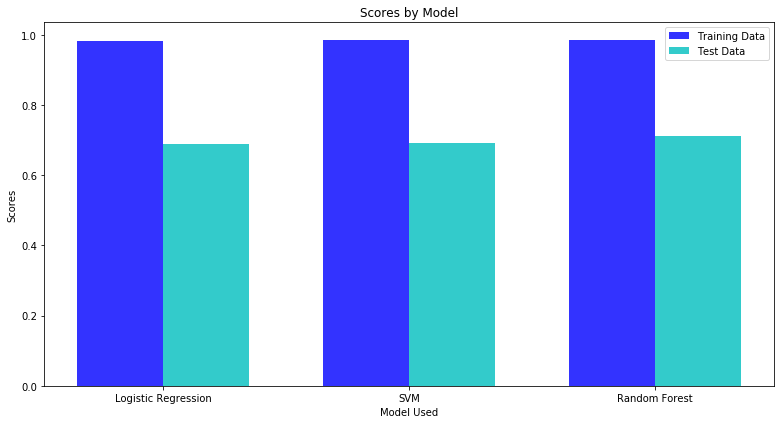

In [85]:
# data to plot
n_groups = 3
train_score = [db_log_clf.score(db_combined_3, db_y_train), 
          db_svm_clf.score(db_combined_3, db_y_train),
          db_rf_clf.score(db_combined_3, db_y_train)]
test_score = [db_log_clf.score(db_test_combined_3, db_y_test), 
          db_svm_clf.score(db_test_combined_3, db_y_test),
          db_rf_clf.score(db_test_combined_3, db_y_test)]

# create plot
fig, ax = plt.subplots(figsize=(11, 6))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, train_score, bar_width,
alpha=opacity,
color='b',
label='Training Data')

rects2 = plt.bar(index + bar_width, test_score, bar_width,
alpha=opacity,
color='c',
label='Test Data')

plt.xlabel('Model Used')
plt.ylabel('Scores')
plt.title('Scores by Model')
plt.xticks(index + bar_width/2, ('Logistic Regression', 'SVM', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()